In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
# 1. Load dataset
df = pd.read_csv('data.csv')

# 2. Mantém apenas músicas a partir de 2000
df = df[df['year'] >= 2000]

# 3. Define features e alvo
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo']
df['target'] = (df['popularity'] > 70).astype(int)

# 4. Remove linhas com dados em falta
df_clean = df.dropna(subset=features + ['target'])

# 5. Cria features combinadas
df_clean['dance_loud'] = df_clean['danceability'] * df_clean['loudness']
df_clean['acoustic_valence'] = df_clean['acousticness'] * df_clean['valence']

features_final = features + ['dance_loud', 'acoustic_valence']

X = df_clean[features_final].values
y = df_clean['target'].values

# 6. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Treino/teste split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)


In [17]:
# 8. Aplica SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 9. Modelo Random Forest
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    random_state=42
)
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=25, n_estimators=200, random_state=42)


Avaliando thresholds com train e test score:


Thresholds: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


Resultados por threshold:
   Threshold  Train-score  Test-score    F1-hit  Recall-hit  Precision-hit
0        0.1     0.806429    0.324970  0.200114    0.910273       0.112414
1        0.2     0.911441    0.535103  0.234102    0.765930       0.138166
2        0.3     0.954077    0.662847  0.246428    0.594278       0.155442
3        0.4     0.975486    0.752232  0.245408    0.434330       0.171019
4        0.5     0.986603    0.811460  0.240156    0.321196       0.191770
5        0.6     0.992418    0.859228  0.237753    0.236671       0.238845
6        0.7     0.994070    0.884680  0.191201    0.146944       0.273608
7        0.8     0.973718    0.900965  0.123799    0.075423       0.345238
8        0.9     0.811121    0.906634  0.037313    0.019506       0.428571


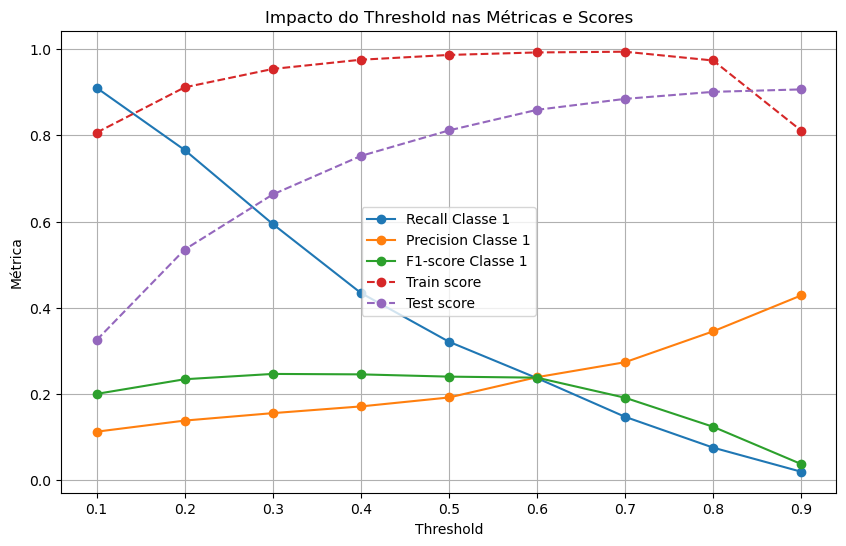

In [18]:
# 9. Função de previsão ajustável por threshold
def predict_with_threshold(model, X_data, threshold=0.5):
    y_probs = model.predict_proba(X_data)[:, 1]
    return (y_probs >= threshold).astype(int)

# 10. Testa thresholds variados
thresholds = [0.1 * i for i in range(1, 10)]  # 0.1 a 0.9
results = []

print("\nAvaliando thresholds com train e test score:")
for threshold in tqdm(thresholds, desc="Thresholds"):
    # Previsões
    y_pred_train = predict_with_threshold(clf, X_train_res, threshold=threshold)
    y_pred_test = predict_with_threshold(clf, X_test, threshold=threshold)
    
    # Accuracy (train/test score)
    train_score = accuracy_score(y_train_res, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)
    
    # Métricas classe 1 (no teste)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    f1_hit = report_test['1']['f1-score']
    recall_hit = report_test['1']['recall']
    precision_hit = report_test['1']['precision']
    
    results.append({
        'Threshold': threshold,
        'Train-score': train_score,
        'Test-score': test_score,
        'F1-hit': f1_hit,
        'Recall-hit': recall_hit,
        'Precision-hit': precision_hit
    })

# 11. Resultados em DataFrame
df_results = pd.DataFrame(results)
print("\nResultados por threshold:")
print(df_results)

# 12. Visualiza evolução do recall, precision, f1-score, train e test score
plt.figure(figsize=(10, 6))
plt.plot(df_results['Threshold'], df_results['Recall-hit'], marker='o', label='Recall Classe 1')
plt.plot(df_results['Threshold'], df_results['Precision-hit'], marker='o', label='Precision Classe 1')
plt.plot(df_results['Threshold'], df_results['F1-hit'], marker='o', label='F1-score Classe 1')
plt.plot(df_results['Threshold'], df_results['Train-score'], marker='o', linestyle='--', label='Train score')
plt.plot(df_results['Threshold'], df_results['Test-score'], marker='o', linestyle='--', label='Test score')
plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Impacto do Threshold nas Métricas e Scores')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Escolhe o threshold que queres
threshold_final = 0.55

# Faz as previsões no treino e no teste
y_pred_train = predict_with_threshold(clf, X_train_res, threshold=threshold_final)
y_pred_test = predict_with_threshold(clf, X_test, threshold=threshold_final)

# Calcula e mostra métricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

train_score = accuracy_score(y_train_res, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)

print(f"\nResultados para threshold={threshold_final}")
print(f"Train score: {train_score:.4f}")
print(f"Test score: {test_score:.4f}")

print("\nMatriz de Confusão no teste:")
print(confusion_matrix(y_test, y_pred_test))

print("\nRelatório de classificação no teste:")
print(classification_report(y_test, y_pred_test))


Resultados para threshold=0.55
Train score: 0.9901
Test score: 0.8366

Matriz de Confusão no teste:
[[6721  800]
 [ 555  214]]

Relatório de classificação no teste:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      7521
           1       0.21      0.28      0.24       769

    accuracy                           0.84      8290
   macro avg       0.57      0.59      0.57      8290
weighted avg       0.86      0.84      0.85      8290



# Gerar o modelo final

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle

# 1. Carrega os dados
df = pd.read_csv('data.csv')

# 2. Mantém apenas músicas a partir de 2000
df = df[df['year'] >= 2000]

# 3. Define features e alvo
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo']
df['target'] = (df['popularity'] > 70).astype(int)

# 4. Remove linhas com dados em falta
df_clean = df.dropna(subset=features + ['target'])

# 5. Cria features combinadas
df_clean['dance_loud'] = df_clean['danceability'] * df_clean['loudness']
df_clean['acoustic_valence'] = df_clean['acousticness'] * df_clean['valence']

features_final = features + ['dance_loud', 'acoustic_valence']

X = df_clean[features_final].values
y = df_clean['target'].values

# 6. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Treino/teste split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# 8. Aplica SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 9. Modelo Random Forest
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    random_state=42
)
clf.fit(X_train_res, y_train_res)

# 10. Guarda o modelo treinado e o scaler em ficheiros .pkl
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n✅ Modelo e scaler guardados como 'random_forest_model.pkl' e 'scaler.pkl'!")

# 11. Escolhe o threshold que queres
threshold_final = 0.55

# Função de previsão com threshold
def predict_with_threshold(model, X_data, threshold=0.5):
    y_probs = model.predict_proba(X_data)[:, 1]
    return (y_probs >= threshold).astype(int)

# Faz as previsões no treino e no teste
y_pred_train = predict_with_threshold(clf, X_train_res, threshold=threshold_final)
y_pred_test = predict_with_threshold(clf, X_test, threshold=threshold_final)

# Calcula e mostra métricas
train_score = accuracy_score(y_train_res, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)

print(f"\nResultados para threshold={threshold_final}")
print(f"Train score: {train_score:.4f}")
print(f"Test score: {test_score:.4f}")

print("\nMatriz de Confusão no teste:")
print(confusion_matrix(y_test, y_pred_test))

print("\nRelatório de classificação no teste:")
print(classification_report(y_test, y_pred_test))



✅ Modelo e scaler guardados como 'random_forest_model.pkl' e 'scaler.pkl'!

Resultados para threshold=0.55
Train score: 0.9901
Test score: 0.8366

Matriz de Confusão no teste:
[[6721  800]
 [ 555  214]]

Relatório de classificação no teste:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      7521
           1       0.21      0.28      0.24       769

    accuracy                           0.84      8290
   macro avg       0.57      0.59      0.57      8290
weighted avg       0.86      0.84      0.85      8290

